# Titanic: Machine Learning From Disaster

!(http://cdn.history.com/sites/2/2014/01/titanic-P.jpeg)

### Foreword

The purpose of this notebook is to demonstrate data science skills using pandas, numpy, matplotlib, scipy and 
scikit learn. Using the Titanic disaster dataset from Kaggle, we will clean, preprocess, and engineer the data before
using scikit learn to build a decent binary classifier which is capable of predicting survival of the Titanic disaster
from the dataset. 

In [75]:
import pandas as pd
import itertools
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from mlxtend.classifier import EnsembleVoteClassifier
from scipy import stats
import warnings
from mlxtend.classifier import StackingClassifier
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
titanic_train = pd.read_csv("train.csv")
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Check for missing values

In [3]:
mask = titanic_train.isnull()
missing = mask.sum(axis=0)
print(missing)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Data Cleaning 

We have many missing values for the Age and Cabin variables. Both of these variables seem like they would have significant predictive power. Luckily we should be able to fill these missing
values with reasonable replacements. In the case of Age, we will use the median value, whereas with the categorical variable Cabin we will simply insert a value that indicates that the Cabin value is unkown. 

There are also two missing values for Embarked. Since we have almost 900 data points, we can simply delete the two with missing values for Embarked. Inserting a placeholder value would  likely result in the model overfitting on these values, as there are only two of them.

### Drop variables we don't use

PassengerId is simply an arbitrary numbering, and we don't need it.

In the case of Name, you would expect the predictive value to be in how Name relates to social class, family status,
and sex. All of these factors are already represented by other variables in our data set. For these reasons it seems
reasonable to drop Name for now. If a decent classifier cannot be built using the other variables it might be worth
reconsidering Name, however it would need extensive engineering to be useful. 

In [4]:
#Drop Name
titanic_train = titanic_train.drop(['Name'], axis=1 )

In [5]:
#Drop passenger id
titanic_train = titanic_train.drop(['PassengerId'], axis=1 )

### Deal with missing Cabin values

We'll just replace empty values with "Unk" for unknown

In [6]:
titanic_train['Cabin'].fillna("unk", inplace=True)
titanic_train['Cabin'] = titanic_train['Cabin'].apply(lambda x: x[0])

### Deal with missing values in 'Age'

In [7]:
# Find the median age for each combination of sex, ticket class and embarkation point
# I would try to do something with number of spouses etc., but they are mixed with number of siblings
def process_missing_age( df ):
    missing_dict = {}
    for tc, sex, ep in [ (t, s, e ) for t in (1, 2, 3) for s in ('male', 'female') for e in ('S', 'Q', 'C')]:
        #print( tc, sex, ep)
        i_set = df.index[ (df[ 'Pclass'] == tc) & (df['Sex'] == sex) & 
                                    (df['Embarked'] == ep) ]
        rows = df.iloc[i_set]
        # Find where we have a missing age
        z_set = rows.index[ rows['Age'].isnull() ]
        med = rows['Age'].median()
        df['Age'].iloc[z_set] = med
        missing_dict[ (tc, sex, ep )] = med
    
process_missing_age( titanic_train )

In [8]:
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,u,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,u,S
3,1,1,female,35.0,1,0,113803,53.1000,C,S
4,0,3,male,35.0,0,0,373450,8.0500,u,S
5,0,3,male,27.0,0,0,330877,8.4583,u,Q
6,0,1,male,54.0,0,0,17463,51.8625,E,S
7,0,3,male,2.0,3,1,349909,21.0750,u,S
8,1,3,female,27.0,0,2,347742,11.1333,u,S
9,1,2,female,14.0,1,0,237736,30.0708,u,C


### Age cleaning results

As we can see, there is a fair bit of information contained in ticket class, sex, and embarkation point that impacts
mean age. If our initial classificaiton results are unsatisfactory, it might be worth checking other variables as
well to get a more granular estimate. 

### Missing values for Embarked

In [9]:
##That's just two values out of ~800 for embarked, so we'll just delete them rather than guess
missing_ind = titanic_train[ titanic_train['Embarked'].isnull()]
print( missing_ind.index )
titanic_train = titanic_train.drop( missing_ind.index )

Int64Index([61, 829], dtype='int64')


### Double check that we have no more missing values

In [10]:
mask = titanic_train.isnull()
missing = mask.sum(axis=0)
print(missing)

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Cabin       0
Embarked    0
dtype: int64


### Examine Data

Examine the data and make some plots to get some information about our variables. 

### Normality

Fare, SibSp ( siblings and spouses on-board ), Parch (parents and children on-board ), and Age  are our numeric variables.

In [11]:
for var in ['Fare', 'Age', 'SibSp', 'Parch']:
    print( var + " Std: %f" % titanic_train[var].std())
    print(var + " Skewness: %f" % titanic_train[var].skew() )
    print( var + " Kurtosis: %f" % titanic_train[var].kurt() )
    print("\n")

Fare Std: 49.697504
Fare Skewness: 4.801440
Fare Kurtosis: 33.508477


Age Std: 13.330126
Age Skewness: 0.515303
Age Kurtosis: 0.677776


SibSp Std: 1.103705
SibSp Skewness: 3.691058
SibSp Kurtosis: 17.838972


Parch Std: 0.806761
Parch Skewness: 2.745160
Parch Kurtosis: 9.750592




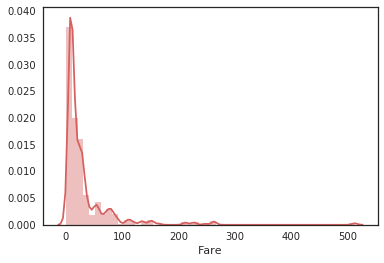

In [12]:
##Investigate Fare
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Fare'], color='r')

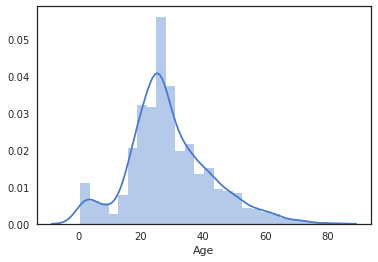

In [13]:
##Investigate Age
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Age'], color='b')

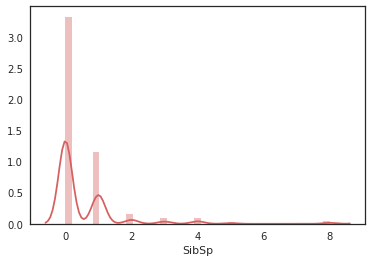

In [14]:
##Investigate SibSp
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['SibSp'], color='r')

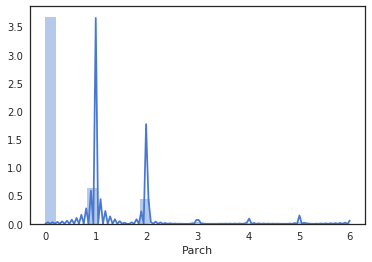

In [15]:
##Investigate Parch
sns.set(style="white", palette="muted", color_codes=True)
#histogram plot for our response variable
sns.distplot(titanic_train['Parch'], color='b')

The only one of these variables that approximates a Gaussian is Age, the rest have a large amount of skew and/or kurtosis. Before we do Feature Engineering or run any sort of Machine Learning algorithm, we will need to transform and scale these distributions. 

### Scatterplots

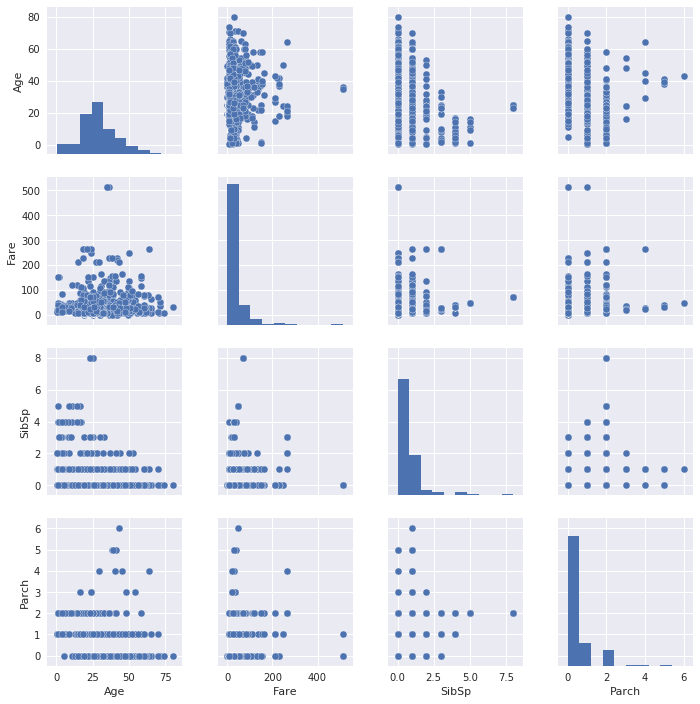

In [16]:
#scatterplot and histogram pair plot
#notice the outliers in the scatter plots
cols=['Age', 'Fare', 'SibSp', 'Parch' ]
sns.set()
sns.pairplot(titanic_train[cols], size = 2.5)
plt.show()

We have a couple of outliers in Fare, which we will deal with before proceeding further. They are rather extreme, and we have enough data that it seems reasonable to delete them if necessary.

However, a little Googling reveals that this would be a mistake. These outliers are not the result of transcription errors, but belong to the Cardeza family ( and their manservant ) who purchased the most expensive tickets available for passage on the Titanic. 

### Feature Engineering

We'll generate appropriate values for our categorical variables using the get_dummies function from pandas, which will give us one-hot encodings for all categorical variables. 

We'll also generate some new numerical features by combining previous features, and transform our numerical features using scaling functions and log-transforms, where necessary.

First, we will deal with Ticket and PClass.

### Pclass is a categorical variable, not numeric

In [17]:
#Pclass is categorical
titanic_train['Pclass'] = titanic_train['Pclass'].astype(str)
def p_conv( entry ):
    e_map = { '1' : 'first', '2': 'second', '3': 'third'}
    return e_map[entry]
titanic_train['Pclass'] = titanic_train['Pclass'].apply(p_conv)
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,third,male,22.0,1,0,A/5 21171,7.2500,u,S
1,1,first,female,38.0,1,0,PC 17599,71.2833,C,C
2,1,third,female,26.0,0,0,STON/O2. 3101282,7.9250,u,S
3,1,first,female,35.0,1,0,113803,53.1000,C,S
4,0,third,male,35.0,0,0,373450,8.0500,u,S
5,0,third,male,27.0,0,0,330877,8.4583,u,Q
6,0,first,male,54.0,0,0,17463,51.8625,E,S
7,0,third,male,2.0,3,1,349909,21.0750,u,S
8,1,third,female,27.0,0,2,347742,11.1333,u,S
9,1,second,female,14.0,1,0,237736,30.0708,u,C


### Define a function to process ticket values

Ticket values are either completely numeric or have an alphabetic prefix to a numeric value.
It can also be hypothesized that, as there appears to be an association between the first number in a ticket
number and the class of that passenger, the first number in a ticket number is the most important. Past this,
it is likely that the number of digits is the most significant piece of information. 

We have, for instance, the ticket numbers "STON/O2. 3101282" and "36973". Six or seven digit ticket numbers starting
with 3 appear to always belong to third class passengers, whereas the five-digit number "36973" belongs to a 
first-class passenger. Similarly, six or sevendigit ticket numbers starting with 2 seem to indicate second class 
passengers.

For these reasons, we will convert Ticket to two categorical variables. One of these variables will contain ticket prefix values, the other will contain the ticket number. 

In [18]:
#How many different values are in the Ticket column before transformation?
len( titanic_train['Ticket'].unique() )

680

In [19]:
#define a function to transform ticket numbers
def ticket_number_processor( ticket_num_array ):
    regex = re.compile('[^a-zA-Z]') #for stripping punctuation from prefixes
    ticket_num = []
    ticket_prefix = []
    for x in range(0, len(ticket_num_array)):
        #there is always whitespace between the prefix and the ticket number
        parts = ticket_num_array[x].split(' ')
        if len(parts) > 1: #we have a prefix
            ticket_prefix.append ( re.sub( regex, '', parts[0] )[:2] ) ##From examing the data, it would appear this much detail is 
            ##sufficient, and indeed optimal. Many of the ticket numbers appear almost identical except for a punct mark
            ticket_num.append( parts[1][0] + str( len(parts[1] )) )
        else: #no prefix
            ticket_prefix.append ("None" ) 
            ticket_num.append( parts[0][0] + str( len(parts[0])) )
    return np.array(ticket_num), np.array(ticket_prefix)      

In [20]:
ticket_nums = titanic_train['Ticket'].as_matrix()
tn, tp = ticket_number_processor( ticket_nums )
titanic_train['TickPrefix'] = pd.Series( tp, index=titanic_train.index )
titanic_train['TickNum'] = pd.Series( tn, index=titanic_train.index )

In [21]:
# Check Ticket column
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TickPrefix,TickNum
0,0,third,male,22.0,1,0,A/5 21171,7.2500,u,S,A,25
1,1,first,female,38.0,1,0,PC 17599,71.2833,C,C,PC,15
2,1,third,female,26.0,0,0,STON/O2. 3101282,7.9250,u,S,ST,37
3,1,first,female,35.0,1,0,113803,53.1000,C,S,None,16
4,0,third,male,35.0,0,0,373450,8.0500,u,S,None,36
5,0,third,male,27.0,0,0,330877,8.4583,u,Q,None,36
6,0,first,male,54.0,0,0,17463,51.8625,E,S,None,15
7,0,third,male,2.0,3,1,349909,21.0750,u,S,None,36
8,1,third,female,27.0,0,2,347742,11.1333,u,S,None,36
9,1,second,female,14.0,1,0,237736,30.0708,u,C,None,26


In [22]:
#How many unique values are in the Ticket column after our transformation?
print( "Number of unique TickNum entries: %d" % len(titanic_train['TickNum'].unique()))
print( "Number of unique TickPrefix entries: %d" % len(titanic_train['TickPrefix'].unique()))

Number of unique TickNum entries: 26
Number of unique TickPrefix entries: 16


We don't want a value in this categorical variable that occurs once, or only a few times. 

In [23]:
unq = titanic_train['TickPrefix'].unique() #get a list of every unique value in 'Ticket' column
tp_cdict = {} 
tn_cdict = {}
for val in unq:
    tp_cdict[val] = len ( titanic_train.index[ titanic_train['TickPrefix'] == val ])
print( "TickPrefix: ")
print( tp_cdict )

unq = titanic_train['TickNum'].unique() #get a list of every unique value in 'Ticket' column
count_dict = {} 
for val in unq:
    tn_cdict[val] = len ( titanic_train.index[ titanic_train['TickNum'] == val ])
print("TickNum")
print( tn_cdict )

TickPrefix: 
{'A': 28, 'PC': 60, 'ST': 18, 'None': 663, 'PP': 5, 'CA': 42, 'SC': 17, 'SP': 1, 'SO': 27, 'WC': 10, 'WE': 3, 'C': 5, 'Fa': 1, 'FC': 6, 'SW': 2, 'AS': 1}
TickNum
{'25': 45, '15': 149, '37': 32, '16': 70, '36': 263, '26': 88, '94': 3, '24': 97, '74': 12, '35': 43, '34': 15, '14': 10, '64': 9, '54': 5, '44': 12, '22': 12, '55': 3, '83': 1, 'L4': 4, '73': 3, '65': 3, 'B5': 1, '45': 3, '63': 2, '84': 2, '31': 2}


In [24]:
#functions to deal with uncommon values in TicketPref and TicketNum
def tp_uncommon( prefix ):
    if tp_cdict[ prefix ] < 6:
        return "Unc"
    else: return prefix

def tn_uncommon( prefix ):
    if tn_cdict[ prefix ] < 10:
        return "Unc"
    else: return prefix

titanic_train['TickPrefix'] = titanic_train['TickPrefix'].apply( tp_uncommon )
titanic_train['TickNum'] = titanic_train['TickNum'].apply( tn_uncommon )

In [25]:
titanic_train = titanic_train.drop(['Ticket'], axis=1)
titanic_train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TickPrefix,TickNum
0,0,third,male,22.0,1,0,7.2500,u,S,A,25
1,1,first,female,38.0,1,0,71.2833,C,C,PC,15
2,1,third,female,26.0,0,0,7.9250,u,S,ST,37
3,1,first,female,35.0,1,0,53.1000,C,S,None,16
4,0,third,male,35.0,0,0,8.0500,u,S,None,36
5,0,third,male,27.0,0,0,8.4583,u,Q,None,36
6,0,first,male,54.0,0,0,51.8625,E,S,None,15
7,0,third,male,2.0,3,1,21.0750,u,S,None,36
8,1,third,female,27.0,0,2,11.1333,u,S,None,36
9,1,second,female,14.0,1,0,30.0708,u,C,None,26


In [26]:
#How many unique values are in the Ticket column after our transformation?
print( "Number of unique TickNum entries: %d" % len(titanic_train['TickNum'].unique()))
print( "Number of unique TickPrefix entries: %d" % len(titanic_train['TickPrefix'].unique()))

Number of unique TickNum entries: 14
Number of unique TickPrefix entries: 10


681 to 28 is a pretty good reduction, although we still have a relatively small sample for that many different values.
There are model types that can handle this, however.


### Split numerical and categorical features, more feature engineering

In [27]:
#categorical, get dummy variables
titanic_cat = titanic_train[['Pclass', 'Sex', 'Embarked', 'TickPrefix', 'TickNum', 'Cabin']]
titanic_cat = pd.get_dummies( titanic_cat )
#numeric
titanic_num = titanic_train[['Age', 'Fare', 'Parch', 'SibSp']]
titanic_cat.head(10)

,Pclass_first,Pclass_second,Pclass_third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,TickPrefix_A,TickPrefix_CA,...,TickNum_Unc,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u
0,0,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
titanic_num.head(10)

,Age,Fare,Parch,SibSp
0,22.0,7.2500,0,1
1,38.0,71.2833,0,1
2,26.0,7.9250,0,0
3,35.0,53.1000,0,1
4,35.0,8.0500,0,0
5,27.0,8.4583,0,0
6,54.0,51.8625,0,0
7,2.0,21.0750,1,3
8,27.0,11.1333,2,0
9,14.0,30.0708,0,1


### Correlation Heatmaps for Categorical Features

These should give us a rough idea of how useful our different features might be during classification. 

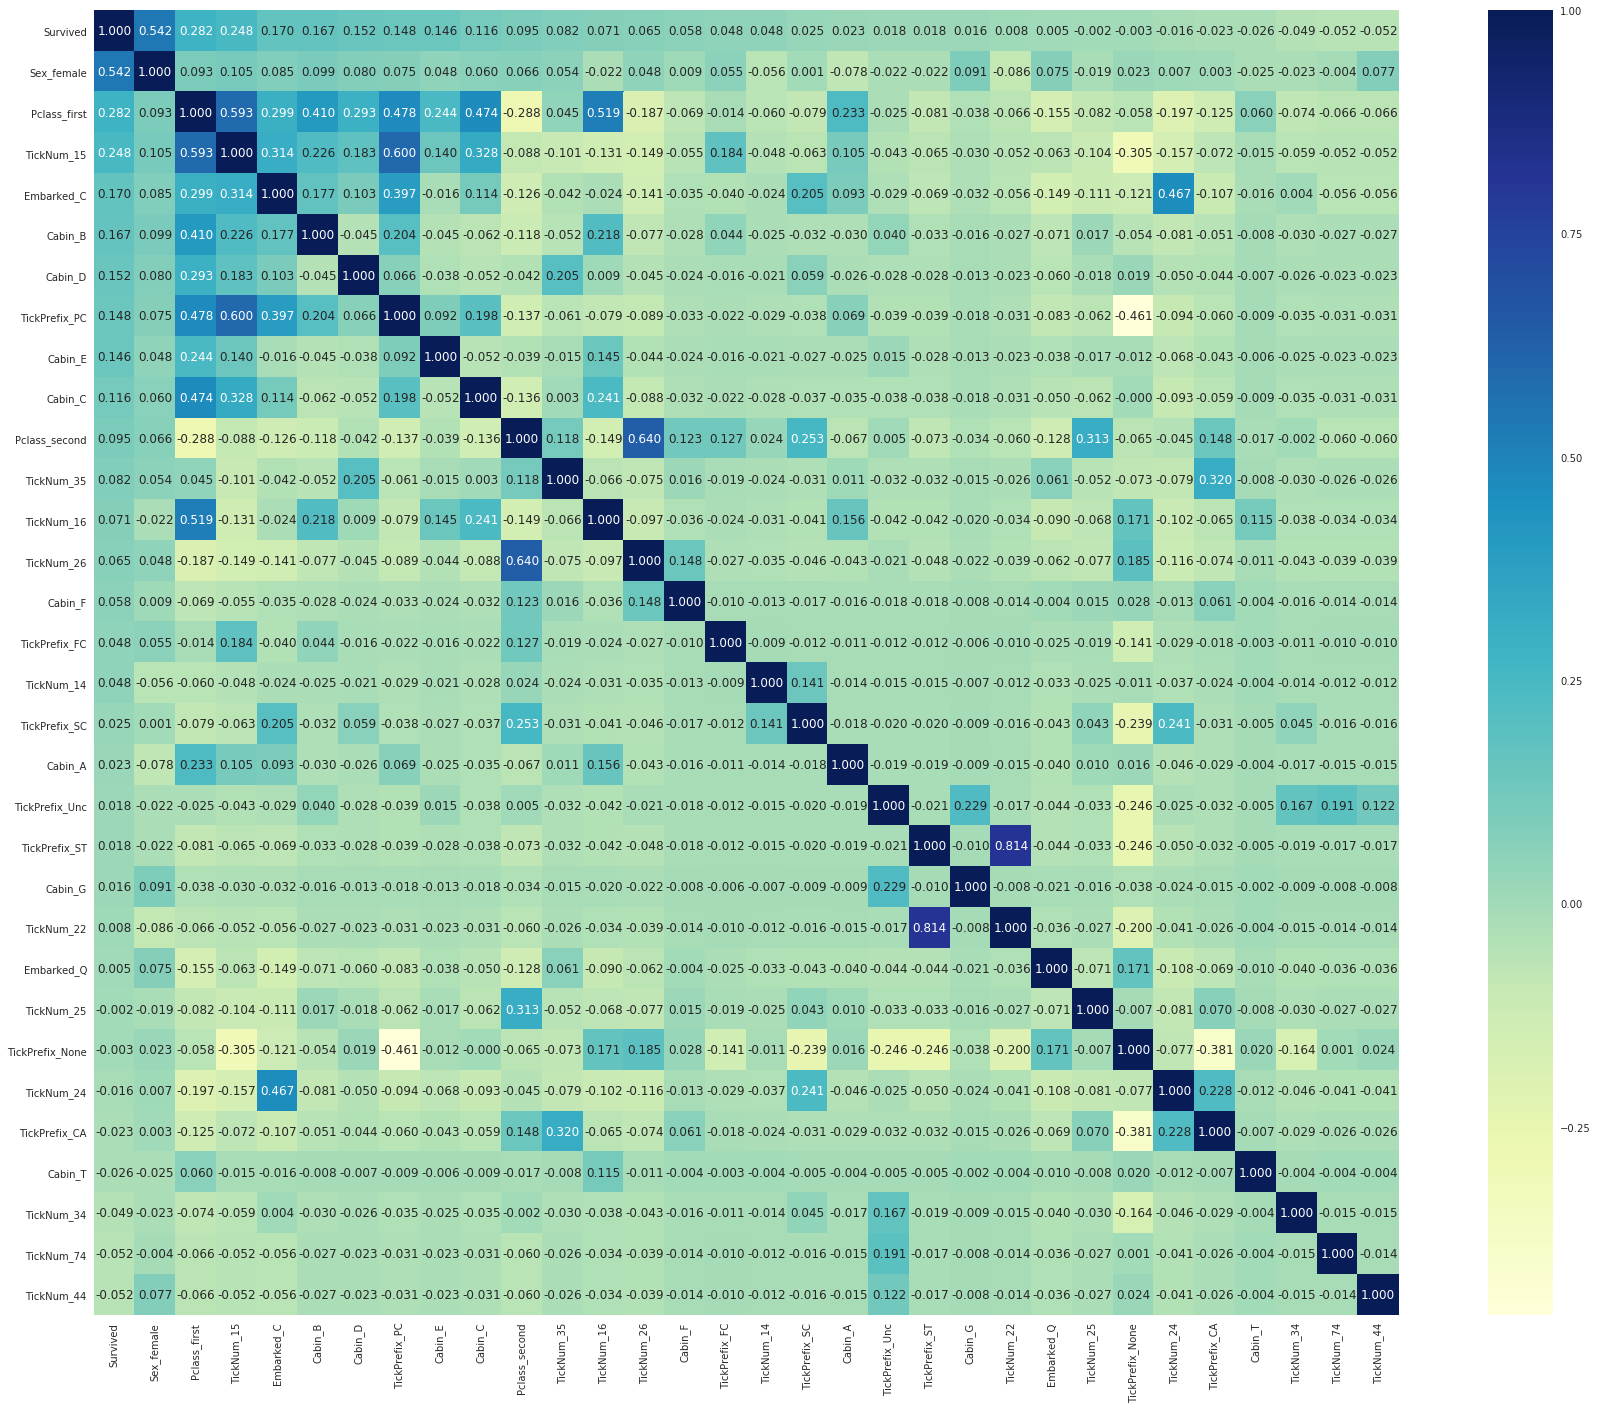

In [29]:
##build a correlation heatmap using the ~10 highest correlated predictors
f, ax = plt.subplots(figsize=(32, 24))
titanic_cat['Survived'] = titanic_train['Survived']
correlation_matrix = titanic_cat.corr()
cols = correlation_matrix.nlargest(32, 'Survived')['Survived'].index
cm = np.corrcoef( titanic_cat[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.3f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### New Features: From Numerical

Our three numerical features are Age, SibSp, Parch, and Fare. We can make some new features here by adding polynomials
on them, additive features with their combinations, and multiplicative features with their combinations

In [30]:
#Check the normality of some of our important predictors
for pred in list(titanic_num.columns.values):
    print( "Results for " + pred + ":" )
    print(stats.normaltest( titanic_num[pred]))
# The p-values reported here are for the null hypothesis that the variable is from a normal distribution
# As we can see, the majority of these variables are likely not from such a distribution
# The 'statistic' value is skewness squared plus kurtosis squared. Many of the non-normal variables have high 
# skewness, kurtosis or both

Results for Age:
NormaltestResult(statistic=46.166360805455206, pvalue=9.4428290258907363e-11)
Results for Fare:
NormaltestResult(statistic=904.42114693266649, pvalue=4.0498905395992859e-197)
Results for Parch:
NormaltestResult(statistic=541.0561334080254, pvalue=3.2445422248648065e-118)
Results for SibSp:
NormaltestResult(statistic=720.58155947033254, pvalue=3.3705632432651391e-157)


In [31]:
#I will apply log-transform to all features where we reject null hypothesis, alpha = 0.01
def get_p( x ):
    s, p = stats.normaltest(x)
    return p
alpha = 0.01
norm_p = titanic_num.apply(lambda x : get_p(x))
norm_p = norm_p[norm_p < alpha]
print(str(norm_p.shape[0]) + " numerical features to log transform")
logt_features = norm_p.index
titanic_num[logt_features] = np.log1p(titanic_num[logt_features])

4 numerical features to log transform


In [32]:
rb = StandardScaler()
def scale_num( df, n_features ):
    for f in n_features:
        df[f] = rb.fit_transform( df[f].as_matrix().reshape(-1,1))
        
def add_quads( df, n_features ):
    for f in n_features:
        df[f + '^2'] = df[f]**2
        
def add_cubes( df, n_features ):
    for f in n_features:
        df[f + '^3'] = df[f]**3
        
def add_additives( df, n_features ):
    combs = list( combinations( n_features, 2 ) )
    for c in combs:
        df[c[0] + '+' + c[1]] = df[c[0]] + df[c[1]]
        
def add_mults( df, n_features ):
    combs = list( combinations( n_features, 2 ) )
    for c in combs:
        df[c[0] + '*' + c[1]] = df[c[0]] * df[c[1]]

num_features = ['Age', 'Fare', 'SibSp', 'Parch']

#scaling
scale_num( titanic_num, num_features )
#polynomials
add_quads( titanic_num, num_features )
add_cubes( titanic_num, num_features )
#additive
add_additives( titanic_num, num_features )
#multiplicative
add_mults( titanic_num, num_features )

In [33]:
titanic_num.head(10)

,Age,Fare,Parch,SibSp,Age^2,Fare^2,SibSp^2,Parch^2,Age^3,Fare^3,...,Age+Parch,Fare+SibSp,Fare+Parch,SibSp+Parch,Age*Fare,Age*SibSp,Age*Parch,Fare*SibSp,Fare*Parch,SibSp*Parch
0,-0.210003,-0.877591,-0.529822,0.887167,0.044101,0.770166,0.787065,0.280711,-0.009261,-0.675891,...,-0.739825,0.009576,-1.407413,0.357345,0.184297,-0.186308,0.111264,-0.778570,0.464967,-0.470041
1,0.641591,1.366380,-0.529822,0.887167,0.411639,1.866993,0.787065,0.280711,0.264104,2.551022,...,0.111769,2.253546,0.836558,0.357345,0.876657,0.569198,-0.339929,1.212207,-0.723938,-0.470041
2,0.048575,-0.796281,-0.529822,-0.610219,0.002360,0.634064,0.372368,0.280711,0.000115,-0.504893,...,-0.481247,-1.406501,-1.326103,-1.140041,-0.038680,-0.029642,-0.025736,0.485906,0.421887,0.323308
3,0.512509,1.066796,-0.529822,0.887167,0.262666,1.138053,0.787065,0.280711,0.134619,1.214071,...,-0.017313,1.953963,0.536974,0.357345,0.546743,0.454681,-0.271539,0.946426,-0.565212,-0.470041
4,0.512509,-0.781901,-0.529822,-0.610219,0.262666,0.611370,0.372368,0.280711,0.134619,-0.478031,...,-0.017313,-1.392121,-1.311723,-1.140041,-0.400732,-0.312743,-0.271539,0.477131,0.414269,0.323308
5,0.107224,-0.736277,-0.529822,-0.610219,0.011497,0.542104,0.372368,0.280711,0.001233,-0.399139,...,-0.422598,-1.346496,-1.266099,-1.140041,-0.078947,-0.065430,-0.056810,0.449290,0.390096,0.323308
6,1.195979,1.042871,-0.529822,-0.610219,1.430365,1.087581,0.372368,0.280711,1.710686,1.134207,...,0.666156,0.432652,0.513049,-1.140041,1.247252,-0.729809,-0.633656,-0.636380,-0.552536,0.323308
7,-3.494805,0.140014,1.153464,2.384553,12.213663,0.019604,5.686093,1.330479,-42.684375,0.002745,...,-2.341341,2.524567,1.293478,3.538017,-0.489321,-8.333548,-4.031131,0.333870,0.161501,2.750496
8,0.107224,-0.478771,2.138123,-0.610219,0.011497,0.229222,0.372368,4.571570,0.001233,-0.109745,...,2.245347,-1.088990,1.659352,1.527904,-0.051336,-0.065430,0.229258,0.292155,-1.023672,-1.304724
9,-0.899326,0.493427,-0.529822,0.887167,0.808787,0.243470,0.787065,0.280711,-0.727363,0.120135,...,-1.429148,1.380593,-0.036395,0.357345,-0.443751,-0.797852,0.476483,0.437752,-0.261428,-0.470041


### Correlation heatmap for our numerical variables


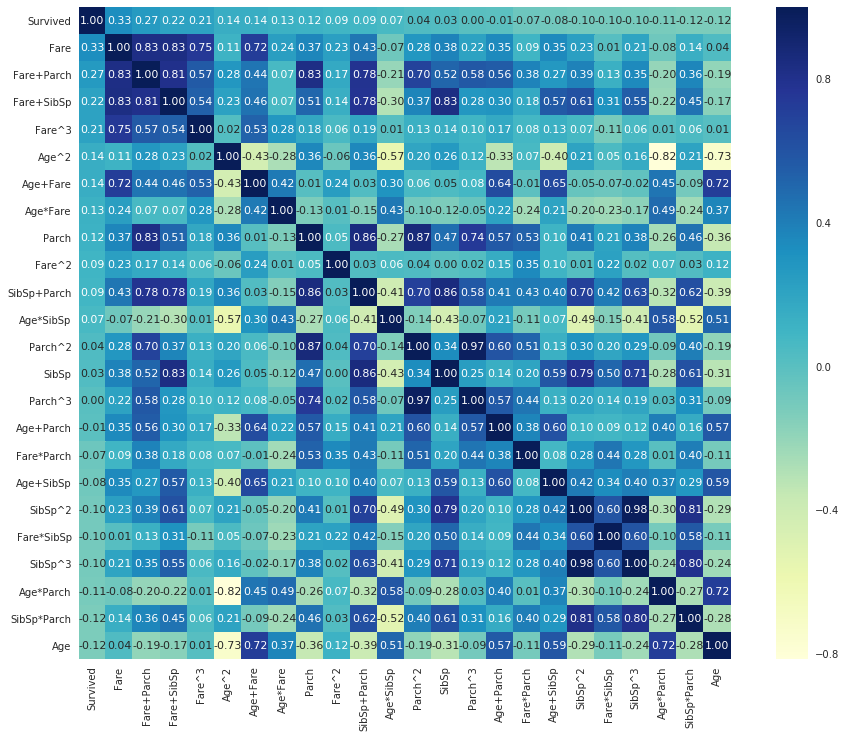

In [34]:
titanic_num['Survived'] = titanic_train['Survived']
f, ax = plt.subplots(figsize=(16, 12))
correlation_matrix = titanic_num.corr()
cols = correlation_matrix.nlargest(24, 'Survived')['Survived'].index
cm = np.corrcoef(titanic_num[cols].values.T)
sns.set(font_scale=1.0)
hm = sns.heatmap(cm, cbar=True, cmap="YlGnBu", annot=True, square=True, fmt='.2f', annot_kws={'size': 11}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [35]:
mask = titanic_num.isnull()
missing = mask.sum(axis=0)
print(missing)

Age            0
Fare           0
Parch          0
SibSp          0
Age^2          0
Fare^2         0
SibSp^2        0
Parch^2        0
Age^3          0
Fare^3         0
SibSp^3        0
Parch^3        0
Age+Fare       0
Age+SibSp      0
Age+Parch      0
Fare+SibSp     0
Fare+Parch     0
SibSp+Parch    0
Age*Fare       0
Age*SibSp      0
Age*Parch      0
Fare*SibSp     0
Fare*Parch     0
SibSp*Parch    0
Survived       0
dtype: int64


### Initial Models

Build some initial models to further assess how useful our new features are, and to benchmark performance.

In [36]:
##helper function for averaging cross val results
def avg(score_arr):
    total = 0.0
    count = 0.0
    for score in score_arr:
        total += score
        count += 1.0
    return total / count

In [37]:
y = titanic_train['Survived']
titanic_num = titanic_num.drop(['Survived'], axis=1)
titanic_cat = titanic_cat.drop(['Survived'], axis=1)
titanic_cat.reset_index(drop=True, inplace=True)
titanic_num.reset_index(drop=True, inplace=True)

In [38]:
titanic_cat.head(10)

,Pclass_first,Pclass_second,Pclass_third,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,TickPrefix_A,TickPrefix_CA,...,TickNum_Unc,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u
0,0,0,1,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6,1,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
7,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
8,0,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [39]:
titanic_cat.shape

(889, 41)

In [40]:
X = pd.concat( [titanic_num, titanic_cat], axis=1)
y.head(5)

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

In [41]:
X.head(5)

,Age,Fare,Parch,SibSp,Age^2,Fare^2,SibSp^2,Parch^2,Age^3,Fare^3,...,TickNum_Unc,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_u
0,-0.210003,-0.877591,-0.529822,0.887167,0.044101,0.770166,0.787065,0.280711,-0.009261,-0.675891,...,0,0,0,0,0,0,0,0,0,1
1,0.641591,1.366380,-0.529822,0.887167,0.411639,1.866993,0.787065,0.280711,0.264104,2.551022,...,0,0,0,1,0,0,0,0,0,0
2,0.048575,-0.796281,-0.529822,-0.610219,0.002360,0.634064,0.372368,0.280711,0.000115,-0.504893,...,0,0,0,0,0,0,0,0,0,1
3,0.512509,1.066796,-0.529822,0.887167,0.262666,1.138053,0.787065,0.280711,0.134619,1.214071,...,0,0,0,1,0,0,0,0,0,0
4,0.512509,-0.781901,-0.529822,-0.610219,0.262666,0.611370,0.372368,0.280711,0.134619,-0.478031,...,0,0,0,0,0,0,0,0,0,1


In [42]:
kn = KNeighborsClassifier(n_neighbors=20)
print( avg(cross_val_score(kn, X, y )))

0.746970455304


In [43]:
svc = svm.SVC()
print( avg(cross_val_score(svc, X, y)))

0.796402463069


In [44]:
log_reg = LogisticRegression(C=0.7, solver='liblinear', tol=1e-8)
print( avg(cross_val_score(log_reg, X, y)))

0.817783692784


In [45]:
ada = AdaBoostClassifier()
print( avg(cross_val_score( ada, X, y)))

0.802052052052


### Hyperparameter Search

We will now do a hyperparamter search on some of these initial models using GridSearchCV, in order to try and find
decent hyperparameters without overfitting. 

In [46]:
"""
Cs = np.array( [ 0.5,0.6, 0.7, 0.8, 0.9] )
tols = np.array( [1e-8, 1e-9, 1e-10, 1e-7 ])
solvers = np.array( ['lbfgs', 'liblinear', 'sag', 'saga'])
param_grid =  { 'C' : Cs, 'tol' : tols, 'solver' : solvers }
gs = GridSearchCV( LogisticRegression(), param_grid )
gs.fit( X, y )
"""

"\nCs = np.array( [ 0.5,0.6, 0.7, 0.8, 0.9] )\ntols = np.array( [1e-8, 1e-9, 1e-10, 1e-7 ])\nsolvers = np.array( ['lbfgs', 'liblinear', 'sag', 'saga'])\nparam_grid =  { 'C' : Cs, 'tol' : tols, 'solver' : solvers }\ngs = GridSearchCV( LogisticRegression(), param_grid )\ngs.fit( X, y )\n"

In [47]:
"""
gs.best_score_
0.82002249718785147
"""

'\ngs.best_score_\n0.82002249718785147\n'

In [48]:
"""
gs.best_params_
{'C': 0.69999999999999996, 'solver': 'liblinear', 'tol': 1e-08}
"""

"\ngs.best_params_\n{'C': 0.69999999999999996, 'solver': 'liblinear', 'tol': 1e-08}\n"

In [49]:
"""
Cs = np.array( [ 300, 400, 500, 600, 700 ] )
gammas = np.array( [2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4] )

param_grid =  { 'C' : Cs, 'gamma' : gammas }
gs = GridSearchCV( svm.SVC(), param_grid )
gs.fit( X, y )
"""

"\nCs = np.array( [ 300, 400, 500, 600, 700 ] )\ngammas = np.array( [2e-4, 3e-4, 4e-4, 5e-4, 6e-4, 7e-4, 8e-4, 9e-4] )\n\nparam_grid =  { 'C' : Cs, 'gamma' : gammas }\ngs = GridSearchCV( svm.SVC(), param_grid )\ngs.fit( X, y )\n"

In [50]:
"""
gs.best_score_
0.82789651293588307
"""

'\ngs.best_score_\n0.82789651293588307\n'

In [51]:
"""
gs.best_params_
{'C': 500, 'gamma': 0.00029999999999999997}
"""

"\ngs.best_params_\n{'C': 500, 'gamma': 0.00029999999999999997}\n"

In [52]:
#XGBoost
"""
max_depths = np.array( [6, 7, 8 ] )
min_child_weights = np.array( [4, 5, 6, 7] )
learning_weights = np.array( [ 0.13, 0.14, 0.15, 0.16, 0.17 ] )
n_estimators = np.array( [50, 75, 80, 90, 100])
param_grid = { 'max_depth' : max_depths, 'min_child_weight' : min_child_weights, 'learning_rate' : learning_weights,
             'n_estimators' : n_estimators }
xgb = xb.XGBClassifier()
gs = GridSearchCV( xgb, param_grid )
"""

"\nmax_depths = np.array( [6, 7, 8 ] )\nmin_child_weights = np.array( [4, 5, 6, 7] )\nlearning_weights = np.array( [ 0.13, 0.14, 0.15, 0.16, 0.17 ] )\nn_estimators = np.array( [50, 75, 80, 90, 100])\nparam_grid = { 'max_depth' : max_depths, 'min_child_weight' : min_child_weights, 'learning_rate' : learning_weights,\n             'n_estimators' : n_estimators }\nxgb = xb.XGBClassifier()\ngs = GridSearchCV( xgb, param_grid )\n"

In [53]:
"""
gs.fit(X,y)
"""

'\ngs.fit(X,y)\n'

In [54]:
"""
gs.best_score_
0.83914510686164234
"""

'\ngs.best_score_\n0.83914510686164234\n'

In [55]:
"""
gs.best_params_
{'learning_rate': 0.14999999999999999,
 'max_depth': 6,
 'min_child_weight': 6,
 'n_estimators': 75}
 """

"\ngs.best_params_\n{'learning_rate': 0.14999999999999999,\n 'max_depth': 6,\n 'min_child_weight': 6,\n 'n_estimators': 75}\n "

In [56]:
rf = RandomForestClassifier(n_estimators=100)
print( avg(cross_val_score( rf, X, y)))

0.814420481087


In [57]:
"""
mlp = MLPClassifier()
param_grid = { 'learning_rate_init' : np.array([2e-4, 3e-4, 1e-4, 4e-4]),
              'max_iter' : np.array([300, 400, 450]),
             }
gs = GridSearchCV( mlp, param_grid )
gs.fit(X,y)
"""

"\nmlp = MLPClassifier()\nparam_grid = { 'learning_rate_init' : np.array([2e-4, 3e-4, 1e-4, 4e-4]),\n              'max_iter' : np.array([300, 400, 450]),\n             }\ngs = GridSearchCV( mlp, param_grid )\ngs.fit(X,y)\n"

In [58]:
"""
gs.best_score_
0.81439820022497189
"""

'\ngs.best_score_\n0.81439820022497189\n'

In [59]:
"""
gs.best_params_
{'learning_rate_init': 0.00020000000000000001, 'max_iter': 300}
"""

"\ngs.best_params_\n{'learning_rate_init': 0.00020000000000000001, 'max_iter': 300}\n"

In [60]:
#'C': 0.69999999999999996, 'solver': 'liblinear', 'tol': 1e-08
log_reg = LogisticRegression(C=7, solver='liblinear', tol=1e-8)
svc = svm.SVC(C=500, gamma=0.0003)
xgb = xb.XGBClassifier( learning_rate=0.15, max_depth=6, min_child_weight=6, n_estimators=75)
rf = RandomForestClassifier(n_estimators=100)
mlp = MLPClassifier( learning_rate_init=0.0001, max_iter=400 )
meta_xgb = MLPClassifier()
stack = StackingClassifier( classifiers=[log_reg, svc, xgb, rf], meta_classifier=meta_xgb)
print( avg(cross_val_score( stack, X, y)))

0.820047320047


In [62]:
vote = EnsembleVoteClassifier( clfs=[log_reg, svc, rf, xgb, mlp], weights=[1,1,1,2,1])
print( avg(cross_val_score( vote, X, y)))

0.831285831286


### Assesment of Classifier Performance

There is some variance in this model, but it tends to clock in between .83 and .84 accuracy on 3-fold cross validation.
This level of performance is commensurate with the top ~5% of entries for this dataset on Kaggle.

We could easily do a GridSearch over the inclusion of the models in EnsembleVoteClassifier and their respective weights to further improve the classifier, but this level of performance is sufficient for the purposes of this notebook. 

### Confusion Matrix

In [63]:
###From scikit learn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
x_pred = X[:300]
x_train = X[300:]
y_cm = y[:300]
y_train = y[300:]

vote.fit( x_train, y_train )
y_pred = vote.predict( x_pred )

Confusion matrix, without normalization
[[172  20]
 [ 33  75]]


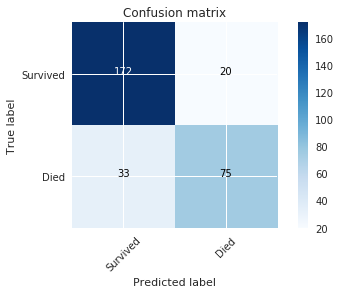

In [76]:
cm = confusion_matrix( y_cm, y_pred )
plot_confusion_matrix( cm, ['Survived', 'Died'] )

It looks like our algorithm has much higher sensitivity than specificity. Besides doing hyperparameter search for our EnsembleVoteClassifier, another route for improvement would be trying to find high specificity classifiers to include in our ensemble, or an analysis of the false positives to ascertain what factors set them apart from the true negatives.